# MDN Hands On Tutorial
This notebook demonstrates the construction of a simple MDN, and compares it to a regular neural network.

Read about MDNs on the [original paper](https://publications.aston.ac.uk/373/1/NCRG_94_004.pdf) by C. Bishop.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

The network we'll construct will try to learn the following relation between $x$ and $f(x)$: 

$$f(x) = x^2-6x+9$$


Note that this simply $y = x^2$ shifted three steps to the left (global minimum is at $x=3$).

In [2]:
def f(x):
    return x**2-6*x+9 

In order to make the data a little bit more relaistic, we'll add a normally-distributed noise, which will be location-dependent - the larger $x$ is, the larger the noisier the data will be. So, our data generator will obey the following relation:

$$g(x) = f(x) + \epsilon(x) $$ 

$$ where: \epsilon(x) = N(0,\sigma_0 x)$$

Where $N(\mu,\sigma)$ is the normal distribution with mean $\mu$ and STD of $\sigma$.

The `data_generator` below function creates $n$ nosiy data samples for a given `x`, where $n$ is defined by `samples`. Notice that technically, `data_generator` yields $g(x) = N(f(x),\sigma_0 x)$, as mathematically that's the same thing. 

In [3]:
def data_generator(x,sigma_0,samples):
    return np.random.normal(f(x),sigma_0*x,samples)

We'll now generate our dataset for $1<x<5$.

The purple line in the plot presents the "clean" function $f(x)$ for this range.

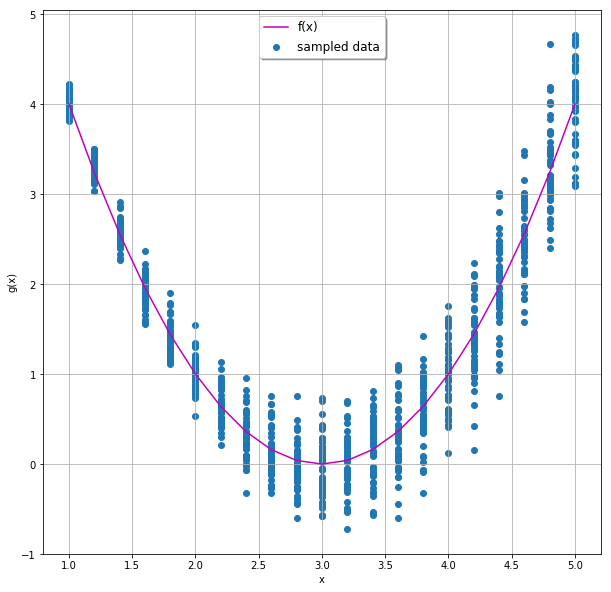

In [4]:
sigma_0 = 0.1
x_vals = np.arange(1,5.2,0.2)
x_arr = np.array([])
y_arr = np.array([])
samples = 50
for x in x_vals:
    x_arr = np.append(x_arr, np.full(samples,x))
    y_arr = np.append(y_arr, data_generator(x,sigma_0,samples))
x_arr, y_arr = shuffle(x_arr, y_arr)
x_test = np.arange(1.1,5.1,0.2)

fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('g(x)')
ax.scatter(x_arr,y_arr,label='sampled data')
ax.plot(x_vals,map(f,x_vals),c='m',label='f(x)')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()

## Regular neural network
We'll now train a neural network which will receive $x$ as input and our noisy $g(x)$ but will have to learn the relation $x \rightarrow f(x)$.

The network is constructed of two hidden layers, each with 12 nodes and the $\tanh(x)$ activation function (note we don't use any activation on the last output layer).

We set the learning rate $\alpha=0.0003$, 50 examples per mini-batch and a total of 500 epoches.

Epoch 0 | cost = 2.8913
Epoch 50 | cost = 1.4886
Epoch 100 | cost = 0.2318
Epoch 150 | cost = 0.1323
Epoch 200 | cost = 0.1114
Epoch 250 | cost = 0.1064
Epoch 300 | cost = 0.1052
Epoch 350 | cost = 0.1047
Epoch 400 | cost = 0.1043
Epoch 450 | cost = 0.1040
Final cost: 0.1038


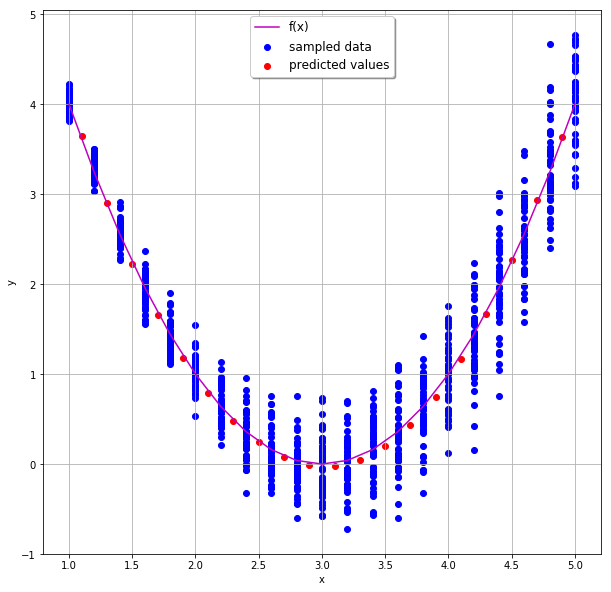

In [5]:
epochs = 500
batch_size = 50
learning_rate = 0.0003
display_step = 50
batch_num = int(len(x_arr) / batch_size)

tf.reset_default_graph()
x = tf.placeholder(name='x',shape=(None,1),dtype=tf.float32)
y = tf.placeholder(name='y',shape=(None,1),dtype=tf.float32)

layer = x
for _ in range(3):
    layer = tf.layers.dense(inputs=layer, units=12, activation=tf.nn.tanh)
output = tf.layers.dense(inputs=layer, units=1)

cost = tf.reduce_mean(tf.losses.mean_squared_error(labels=y,predictions=output))

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
x_batches = np.array_split(x_arr, batch_num)
y_batches = np.array_split(y_arr, batch_num)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        avg_cost = 0
        for i in range(batch_num):
            x_batch = np.expand_dims(x_batches[i],axis=1)
            y_batch = np.expand_dims(y_batches[i],axis=1)
            _, c = sess.run([optimizer,cost], feed_dict={x:x_batch, y:y_batch})
            avg_cost += c/batch_num
        if epoch % display_step == 0:
            print('Epoch {0} | cost = {1:.4f}'.format(epoch,avg_cost))
    y_pred = sess.run(output,feed_dict={x:np.expand_dims(x_test,axis=1)})
    print('Final cost: {0:.4f}'.format(avg_cost))

fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
ax.scatter(x_arr,y_arr,c='b',label='sampled data')
ax.scatter(x_test,y_pred,c='r',label='predicted values')
ax.plot(x_vals,map(f,x_vals),c='m',label='f(x)')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()

It seems to be doing quite good in predicting $f(x)$, but we can clearly see that the network learnt nothing about the size of the noise. 

## Mixture density network (MDN)
Let's try an MDN now. We'll use the same network as in the previous section, with one important change:
the output layer now has two nodes (which are constructed as two layers of 1 node for technical simplicity), which we named `mu` and `sigma`

Note the new cost function: we create a normal distribution out of the predicted `mu` and `sigma`, and then minimize the negative log-likelihood of this distribution yielding the traget value `y`. Mathematically, our cost function is the negative logarithm of the normal distribution's probability density function (PDF):

$$PDF = -\log\left(\frac{1}{\sqrt{2\pi\sigma}}\cdot\exp{\left[-\frac{(y-\mu)^{2}}{2\sigma^{2}}\right]}\right)$$

In [6]:
def mdn_cost(mu, sigma, y):
    dist = tf.distributions.Normal(loc=mu, scale=sigma)
    return tf.reduce_mean(-dist.log_prob(y))

We'll use `elu + 1` as the activation function for `sigma`, as it must always be non-negative. The Exponential Linear Unit (ELU) is defined as:

$$ ELU(x) = \begin{cases} x & x\ge0 \\ \exp{(x)}-1 & x < 0 \end{cases} $$

Epoch 0 | cost = 1.9961
Epoch 50 | cost = 1.4238
Epoch 100 | cost = 0.4021
Epoch 150 | cost = 0.3326
Epoch 200 | cost = 0.2841
Epoch 250 | cost = 0.2463
Epoch 300 | cost = 0.2159
Epoch 350 | cost = 0.1916
Epoch 400 | cost = 0.1730
Epoch 450 | cost = 0.1596
Final cost: 0.1505


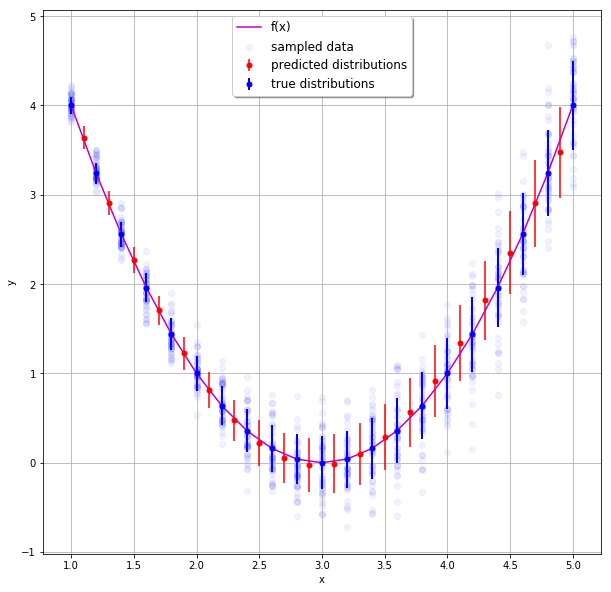

In [7]:
epochs = 500
batch_size = 50
learning_rate = 0.0003
display_step = 50
batch_num = int(len(x_arr) / batch_size)

tf.reset_default_graph()
x = tf.placeholder(name='x',shape=(None,1),dtype=tf.float32)
y = tf.placeholder(name='y',shape=(None,1),dtype=tf.float32)

layer = x
for _ in range(3):
    layer = tf.layers.dense(inputs=layer, units=12, activation=tf.nn.tanh)
mu = tf.layers.dense(inputs=layer, units=1)
sigma = tf.layers.dense(inputs=layer, units=1, activation=lambda x: tf.nn.elu(x) + 1)

cost = mdn_cost(mu, sigma, y)

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
x_batches = np.array_split(x_arr, batch_num)
y_batches = np.array_split(y_arr, batch_num)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        avg_cost = 0.0
        for i in range(batch_num):
            x_batch = np.expand_dims(x_batches[i],axis=1)
            y_batch = np.expand_dims(y_batches[i],axis=1)
            _, c = sess.run([optimizer,cost], feed_dict={x:x_batch, y:y_batch})
            avg_cost += c/batch_num
        if epoch % display_step == 0:
            print('Epoch {0} | cost = {1:.4f}'.format(epoch,avg_cost))
    mu_pred, sigma_pred = sess.run([mu,sigma],feed_dict={x:np.expand_dims(x_test,axis=1)})
    print('Final cost: {0:.4f}'.format(avg_cost))

fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
ax.errorbar(x_test,mu_pred,yerr=np.absolute(sigma_pred),c='r',ls='None',marker='.',ms=10,label='predicted distributions')
ax.scatter(x_arr,y_arr,c='b',alpha=0.05,label='sampled data')
ax.errorbar(x_vals,map(f,x_vals),yerr=map(lambda x: sigma_0*x,x_vals),c='b',lw=2,ls='None',marker='.',ms=10,label='true distributions')
ax.plot(x_vals,map(f,x_vals),c='m',label='f(x)')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()

The plot above shows the results learnt by the network. In red are the networks predictions for $\mu$ and $\sigma$, and in blue are the actual $\mu$ and $\sigma$ used for the training set. The actual data can be seen faded in the background. We can clearly see the network has learnt not just $x \rightarrow f(x)$, but also the noise creating $x \rightarrow g(x)$.